In [ ]:
import numpy as np
import cv2

img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Stack_9frames__WithDisplayStretch.png")

from google.colab.patches import cv2_imshow
cv2_imshow(img)

print(img.shape)
x = []
y= []
z=[]
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
      if i%100==0 and j%100==0:
        x.append(i)
        y.append(j)
        z.append(img[i,j,0])

import scipy
#print("img=",img)
#print("img2=",img2)
#print("img3",img3)

img4 = cv2.medianBlur(img2, 5)
cv2_imshow(img4)

def crop(img,x,y,h,w):
  return img[x:x+h,y:y+w, :]

#x,y:窓サイズ、 dx,dy:ずらし量
def explore(base_img,img, dx,dy):
  x=img.shape[0]
  y=img.shape[1]
  max = -100
  i_max, j_max = 0,0
  for i in range(int((base_img.shape[0]-x)/dx)):
    for j in range(int((base_img.shape[1]-y)/dy)):
      #i*dx, i*dyは切り抜く画像の右)上の座標
      ruizido=np.sum(np.multiply(crop(base_img,i*dx,j*dy,x,y)[:,:,0],img[:,:,0]))
      #print("ruizido=",ruizido)
      if ruizido>max:
        max=ruizido
        i_max, j_max = i,j

  cv2_imshow(crop(base_img, i_max*dx, j_max*dy,x,y))


cv2_imshow(crop(img2,500,1750,200,200))
explore(img2, crop(img2,400,1600,400,500),10,10)

#AKAZE検出器の生成
akaze = cv2.AKAZE_create()

kp_map, des_map = akaze.detectAndCompute(crop(img2,500,1750,200,200), None)
kp_img2, des_img2 = akaze.detectAndCompute(img2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des_img2, des_map, k=2)


out1 = cv2.drawKeypoints(crop(img2,500,1750,200,200),kp_map,None)
out2 = cv2.drawKeypoints(img2,kp_img2,None)

#マッチング器cv2.BFMatcherオブジェクトの生成
matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
#2つの特徴量からマッチング実施、マッチする
matches = matcher.match(des_map,des_img2)
print('distance:', matches[1].distance)
print('trainIdx:', matches[1].trainIdx)
print('queryIdx:', matches[1].queryIdx)


#2つの画像から得られるキーポイントのマッチするもの同士を出力画像に描画
dst = cv2.drawMatches(crop(img2,500,1750,200,200),kp_map,img2,kp_img2,matches, None, flags=2)
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
plt.show()
print(matches)

https://chantastu.hatenablog.com/entry/2022/09/15/234947

templ=crop(img2,500,1750,200,200)
result = cv2.matchTemplate(img2,                  #対象画像
                           templ,                #テンプレート画像
                           cv2.TM_CCOEFF_NORMED  #類似度の計算方法
                           )

#類似度の閾値
threshold =0.95
#類似度が閾値以上の座標を取得
match_y, match_x = np.where(result >= threshold)

#テンプレート画像のサイズ
w = templ.shape[1]
h = templ.shape[0]

#対象画像をコピー
dst = img2.copy()

#マッチした箇所に赤枠を描画
#赤枠の右下の座標は左上の座標（x,y)にテンプレート画像の幅、高さ(w,h）を足す。
for x,y in zip(match_x, match_y):
    cv2.rectangle(dst,        #対象画像
                  (x,y),      #マッチした箇所の左上座標
                  (x+w, y+h), #マッチした箇所の右下座標
                  (0,0,225),  #線の色
                  2           #線の太さ
                  )

plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
plt.show()


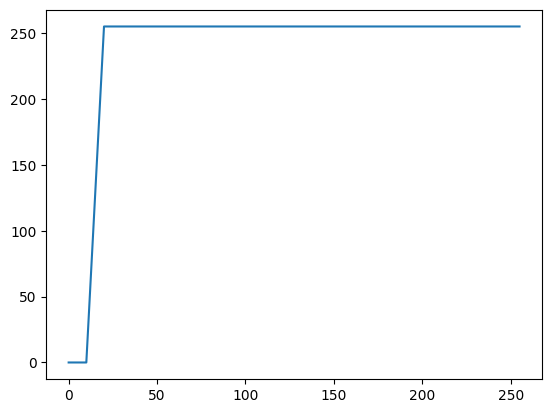

D:\SharpCap Captures\2024-10-20\Capture\19_41_31\rawframes\frame_00001.png
<class 'numpy.ndarray'>


: 

In [2]:
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy import interpolate
def read_imgs(folder_path):
  files=glob.glob(folder_path)
  """
  imgs = []
  for file in files:
    imgs.append(cv2.imread(file))
  """
  return files

files = read_imgs(r"D:\SharpCap Captures\2024-10-20\Capture\19_41_31\rawframes/*png*")


#img = cv2.imread(files[0])

#ヒストグラムをプロットする
def plot_hist(img, channel):
  cv2_imshow(img)
  img_hist_cv = cv2.calcHist([img], [channel], None, [256], [0, 256])
  plt.plot(img_hist_cv)
  plt.show()
  print(len(img_hist_cv))

  pixel_num = img.shape[0]*img.shape[1]
  pixel_num_cumulative = 0
  min = None
  max = None
  for i in range(256):

    pixel_num_cumulative+=img_hist_cv[i]
    if pixel_num_cumulative/pixel_num >0.05 and min == None:
      min = i
    if pixel_num_cumulative/pixel_num >0.5 and max == None:
      max = i
      break
  print(min,max)


#トーンカーブを変える関数
def tone_curve(min,mid,max):
  x=[min, mid, max]
  y=[0,0.5,1]
  popt,pcov = scipy.optimize.curve_fit(func,x,y)
  kind = 'slinear'
  f = interpolate.interp1d(x, y, kind=kind)
  return f

#線形なトーンカーブ
def tone_curve_linear(min,max):
    a = 256/(max-min)
    b = -a*min
    tone_list = []
    for i in range(256):
        f = a*i+b
        if f < 0:
            tone_list.append(0)
        elif f > 255:
            tone_list.append(255)
        else:
            tone_list.append(f)
    return tone_list

def apply_tone_curve(img, tone_list):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(3):
                img[i,j,k] = tone_list[img[i,j,k]]
    return img
#plot_hist(img, 0)

tone_list_linear = tone_curve_linear(10,20)
plt.plot(tone_list_linear)
plt.show()
print(files[0])
img = cv2.imread(files[0])
print(type(img))
cv2.imshow("",img)
cv2.imshow("",apply_tone_curve(img,tone_list_linear))

In [ ]:
def func(X, a,b, c,d,e,f,g, h, i ,j):
  x=X[0]
  y=X[1]
  return a*x**3+b*x**2+c*x + d*y**3+e*y**2+f*y+ g*x**2*y + h*x*y**2 + i*x*y +j
popt,pcov = scipy.optimize.curve_fit(func,np.array([y,x]),z)
print(popt)

from scipy.stats import norm
import math

standa = [norm.pdf(i, loc=0, scale=1 ) for i in range(256)]
standa2 = [math.exp(-i**2/(2*50**2)) for i in range(256)]

from matplotlib import pyplot as plt
plt.plot(standa2)
plt.show()

def estimate_and_subtrack_background(img, func):
img2=img.copy()
img3=img.copy()
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    for k in range(img.shape[2]):
      back_ground = func([j,i],popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7], popt[8], popt[9])
      img3[i,j,k] = back_ground
      hosei = back_ground*standa2[int(abs(img[i,j,k]-back_ground))]
      if img[i,j,k] - hosei>0:
        img2[i,j,k] = img[i,j,k] - hosei
      else:
        img2[i,j,k] = 0

cv2_imshow(img2)
cv2_imshow(img3)